O código base da árvore e da floresta foi feito em cima do código disponibilizado no canal AssemblyAI no Youtube.

## Imports

In [9]:
# Bibliotecas Necessárias:

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import Counter
import copy
import matplotlib.pyplot as plt

## Base - Nó e Árvore

In [10]:
#Nó:

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None, nodeValues=[], depth=None, index=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.nodeValues = nodeValues
        self.depth = depth
        self.index = index

    def is_leaf_node(self):
        return self.value is not None

# Árvore:

class DecisionTree:
    def __init__(self, minSamplesToSplit=2, maxDepth=100, treeDepth=0, numFeatures=None, mode=0):
        self.minSamplesToSplit = minSamplesToSplit
        self.maxDepth = maxDepth
        self.treeDepth = treeDepth
        self.numFeatures = numFeatures
        self.rootNode = None
        self.split_criterion = self.general_entropy if mode == 0 else self.variance_reduction
        self.calculate_leaf_value = self._most_common_label if mode == 0 else self._mean_values
        self.accuracy_function = self.classification_accuracy if mode == 0 else self.regression_accuracy
        self.treeShape = []
        self.evaluation = 0


    def fit(self, data, label):
        self.numFeatures = data.shape[1] if not self.numFeatures else min(data.shape[1],self.numFeatures)
        self.rootNode = self._grow_tree(data, label)


    def _grow_tree(self, data, label, depth=0):
        num_samples, numFeatures = data.shape
        num_labels = len(np.unique(label))

        if (depth >= self.maxDepth or num_labels <= 1 or num_samples < self.minSamplesToSplit):
            if depth > self.treeDepth:
                self.treeDepth = depth
            leaf_value = self._calculate_leaf_value(label)
            return Node(value=leaf_value, nodeValues=label, depth=depth)

        feature_indexs = np.random.choice(numFeatures, self.numFeatures, replace=False)

        best_feature, best_threshold = self._best_split(data, label, feature_indexs)

        left_indexs, right_indexs = self._split(data[:, best_feature], best_threshold)

        left = self._grow_tree(data[left_indexs, :], label[left_indexs], depth+1)
        right = self._grow_tree(data[right_indexs, :], label[right_indexs], depth+1)
        return Node(best_feature, best_threshold, left, right, depth=depth)


    def _best_split(self, data, label, feature_indexs):
        best_gain = -1
        split_indexs, split_threshold = None, None

        for feature_index in feature_indexs:
            data_column = data[:, feature_index]
            thresholds = np.unique(data_column)

            for threshold in thresholds:
                gain = self.information_gain(data_column, label, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold

        return split_index, split_threshold

    def information_gain(self, data_column, label, threshold):
        left_indexs, right_indexs = self._split(data_column, threshold)

        if len(left_indexs) == 0 or len(right_indexs) == 0:
            return 0

        left_weight = len(left_indexs) / len(label)
        right_weight = len(right_indexs) / len(label)

        return self.split_criterion(label, left_indexs, right_indexs, left_weight, right_weight)


    def _split(self, data_column, split_threshold):
        left_indexs = np.argwhere(data_column <= split_threshold).flatten()
        right_indexs = np.argwhere(data_column > split_threshold).flatten()

        return left_indexs, right_indexs


    def general_entropy(self, label, left_indexs, right_indexs, left_weight, right_weight):
        label_weight = len(label)
        label_entropy = self.entropy(label)
        left_entropy = self.entropy(label[left_indexs])
        right_entropy = self.entropy(label[right_indexs])
        child_entropy = (left_weight/label_weight) * left_entropy + (right_weight/label_weight) * right_entropy

        return label_entropy - child_entropy

    def entropy(self, label):
        label_weight = len(label)
        histogram = np.bincount(label)
        probabilities = histogram / label_weight

        return -np.sum([probabilitie * np.log(probabilitie) for probabilitie in probabilities if probabilitie>0])

    def variance_reduction(self, label, left_indexs, right_indexs, left_weight, right_weight):
        return np.var(label) - (left_weight * np.var(left_indexs) + right_weight * np.var(right_indexs))


    def _calculate_leaf_value(self, label):
        return self.calculate_leaf_value(label)

    def _most_common_label(self, label):
        counter = Counter(label)
        value = counter.most_common(1)[0][0]

        return value

    def _mean_values(self, label):
        if len(label) > 0: return np.mean(label)
        else: return 0


    def predict(self, data):
        return np.array([self._traverse_tree(x, self.rootNode, None, None) for x in data])

    def _traverse_tree(self, x, node, threshold, feature):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left, node.threshold, x[node.feature])

        return self._traverse_tree(x, node.right, node.threshold, x[node.feature])


    def accuracy(self, test_label, prediction_label):
        return self.accuracy_function(test_label, prediction_label)

    def classification_accuracy(self, test_label, prediction_label):
        accuracy = np.sum(test_label == prediction_label) / len(test_label)
        return accuracy

    def regression_accuracy(self, test_label, prediction_label):
        from sklearn.metrics import mean_squared_error
        mean_squared_error = np.sqrt(mean_squared_error(test_label, prediction_label))

        return mean_squared_error

## Random Forest

In [11]:
# Floresta:

class RandomForest:
    def __init__(self, num_trees=10, maxDepth=10, minSamplesToSplit=2, num_feature=None, mode=0):
        self.num_trees = num_trees
        self.maxDepth=maxDepth
        self.minSamplesToSplit=minSamplesToSplit
        self.numFeatures=num_feature
        self.trees = [] # Vai armazenar as árvores
        self.mode = mode
        self.calculate_predict = self._most_common_label if mode == 0 else self._mean_values

    def fit(self, data, label):
        self.trees = []
        for i in range(self.num_trees):
            print(f"Round Geral: {i}")
            tree = DecisionTree(maxDepth=self.maxDepth,
                                minSamplesToSplit=self.minSamplesToSplit,
                                numFeatures=self.numFeatures, mode=self.mode)

            data_sample, label_sample = self._bootstrap_samples(data, label)
            tree.fit(data_sample, label_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, data, label):
        num_samples = data.shape[0]
        indexs = np.random.choice(num_samples, num_samples, replace=True)
        return data[indexs], label[indexs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def _mean_values(self, label):
        if len(label) > 0: return np.mean(label)
        else: return 0

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self.calculate_predict(pred) for pred in tree_preds])
        return predictions

    def accuracy(self, test_label, prediction_label):
        return self.accuracy_function(test_label, prediction_label)

## Otimização - Pruning

In [3]:
# Podador:

class TreePruner:
    def __init__(self):
        self.treesWarehouse = []
        self.treesScoreAndAlpha = []
        self.nodeCounter = 0


    def prune_tree(self, tree): # Repetir o processo de corte até sobrar somente o nó raiz
        self.index_tree(tree.rootNode)
        self.display_tree(tree, tree.rootNode)

        num_treshold = 0
        for i in tree.treeShape:
            if i[0] != None:
                num_treshold += 1

        save_tree = copy.deepcopy(tree)
        self.treesWarehouse.append(save_tree)

        tree.treeShape = []

        for _ in range(num_treshold-1):
            tree = self.slice_nodes(tree)
            tree.treeShape = []

    def search_node(self, node, index):
        if not node.is_leaf_node():
            if node.index != index: # Retorna os valores necessários e continua
                self.search_node(node.left, index)
                self.search_node(node.right, index)
            else:
                self.extra = node

    def slice_nodes(self, tree): # Cortar os ultimos node leafs e transformar o threshold em leaf node
        targetNode, tree = self.locate_index_to_cut(tree)
        node = tree.rootNode
        self.search_node(node, targetNode)
        targetNode = self.extra

        if targetNode.left != None:
            targetNode.nodeValues = targetNode.left.nodeValues
            del targetNode.left
            targetNode.left = None
        if targetNode.right != None:
            if len(targetNode.nodeValues) == 0:
                targetNode.nodeValues = targetNode.right.nodeValues
            else:
                targetNode.nodeValues = np.concatenate((targetNode.nodeValues, targetNode.right.nodeValues))

            del targetNode.right
            targetNode.right = None

        targetNode.value = tree._calculate_leaf_value(targetNode.nodeValues)
        targetNode.threshold = None

        tree.treeShape = []
        self.display_tree(tree, tree.rootNode)
        tree_tree = tree.treeShape
        save_tree = copy.deepcopy(tree)
        self.treesWarehouse.append(save_tree)

        return tree

    def index_tree(self, node):
        node.index = self.nodeCounter
        self.nodeCounter += 1
        if not node.is_leaf_node():
            self.index_tree(node=node.left)
            self.index_tree(node=node.right)


    def display_tree(self, tree, node, direction=0):
        tree.treeShape.append([node.threshold, direction, node.depth, node.index])
        if not node.is_leaf_node(): # Retorna os valores necessários e continua
            self.display_tree(tree, node.left, 1)
            self.display_tree(tree, node.right, 2)

    def locate_index_to_cut(self, tree):
        self.nodeCounter = 0
        self.index_tree(tree.rootNode)
        self.display_tree(tree, tree.rootNode)
        tree_tree = tree.treeShape

        depth = -1
        index = 0
        for node in tree_tree:
            if node[0] != None and node[2] > depth:
                depth = node[2]
                index = node[3]
        tree.treeShape = []
        return index, tree

    def search_leaf_nodes(self, tree) -> int:
        leafs = 0
        for i in tree.treeShape:
            if i[0] == None:
                leafs += 1

        return leafs

In [4]:
# Funções Auxiliares:

modular = lambda x: x if x >= 0 else x*-1

def gerar_lista_de_elementos(elemento, num_de_elementos:int) -> list:
    return [copy.deepcopy(elemento) for _ in range(num_de_elementos)]

def calculateSumOfSquaredResiduals(prediction_label:list, test_label:list) -> int:
    ssr = 0
    for x in range(len(test_label)):
        ssr += (test_label[x] - prediction_label[x])**2

    return ssr

def find_divisors(number:int) -> list:
    divisors = []
    for i in range(1, number+1):
        if number % i == 0:
            divisors.append(i)

    return divisors

def exibir(i, pruner, data_test, label_test) -> None:
    print("##########################")
    print(f"Meio Termo 1:\nIndex: {i}")
    print(pruner.treesWarehouse[i].treeShape)
    numberOfNodes = len(pruner.treesWarehouse[i].treeShape)
    print(f"Número de Nós: {numberOfNodes}")
    predictions = pruner.treesWarehouse[i].predict(data_test)
    evaluation = pruner.treesWarehouse[i].accuracy(label_test, predictions)
    print(f"Evaluation: {evaluation}")
    return numberOfNodes

In [12]:
# Ten Cross Validation - Precisa ser refatorado

class TenCrossValidation:
    def __init__(self, fullData:list, fullLabel:list, evaluationList:list=[]):
        self.fullData = fullData
        self.fullLabel = fullLabel
        self.evaluationList = evaluationList

    def find_best_models(self, divisor:int, mode:int):
        print("Fase Inicial:")
        TCV.cross_validation(divisor, mode)

        print("\n")
        print("Fase Final:")

        total = 0
        for i in TCV.evaluationList:
            total += i

        print(total, len(TCV.evaluationList))

        alpha = total/len(TCV.evaluationList)

        evaluationWarehouse = []
        numberOfNodesWarehouse = []

        model = DecisionTree(maxDepth=500, mode=mode)
        model.fit(data_train, label_train)

        predictions = model.predict(data_train)
        tree_result = model.accuracy(label_train, predictions)

        pruner = TreePruner()
        pruner.prune_tree(model)

        predictions = pruner.treesWarehouse[0].predict(data_train)
        bestEvaluationMetric = pruner.treesWarehouse[0].accuracy(label_train, predictions)
        bestIdx = 0

        minTreeScore = None
        idxTreeScore = 0

        for i in range(len(pruner.treesWarehouse)):
            if i % 1 == 0:
                print(f"Round: {i}")
                numberOfNodes = len(pruner.treesWarehouse[i].treeShape)
                print(f"Número de Nós: {numberOfNodes}")
                predictions = pruner.treesWarehouse[i].predict(data_train)
                evaluationMetric = pruner.treesWarehouse[i].accuracy(label_train, predictions)
                if mode == 0: evaluationMetric = 1 - evaluationMetric
                pruner.treesWarehouse[i].evaluationList = evaluationMetric
                numberOfLeafs = pruner.search_leaf_nodes(pruner.treesWarehouse[i])

                if mode == 0:
                    treeScore = 10*evaluationMetric-alpha*numberOfLeafs
                    modular = lambda x: x if x >= 0 else x*-1
                    treeScore = modular(treeScore)
                else:
                    treeScore = evaluationMetric+alpha*numberOfLeafs

                print(f"Leafs: {numberOfLeafs}")
                print(f"SSR: {evaluationMetric}")
                print(f"Tree Score: {treeScore}")

                if minTreeScore == None:
                    minTreeScore = treeScore

                if treeScore < minTreeScore:
                    minTreeScore = treeScore
                    idxTreeScore = i

                if evaluationMetric < bestEvaluationMetric:
                    bestEvaluationMetric = evaluationMetric
                    idxMinSSR = i

                evaluationWarehouse.append(evaluationMetric)
                numberOfNodesWarehouse.append(numberOfNodes)

                print("\n")

        bestModels = []

        print("#########################")
        print(f"First Tree")
        print(f"Número de Nós: {len(pruner.treesWarehouse[0].treeShape)}")
        predictions = pruner.treesWarehouse[0].predict(data_test)
        evaluation = pruner.treesWarehouse[0].accuracy(label_test, predictions)
        print(f"Evaluation: {evaluation}")

        print("\n")

        meioTermo = int(f"{idxTreeScore/2:.0f}")
        print("##########################")
        print(f"Meio Termo 1:\nIndex: {meioTermo}")
        print(pruner.treesWarehouse[meioTermo].treeShape)
        numberOfNodesEscolhido = len(pruner.treesWarehouse[meioTermo].treeShape)
        print(f"Número de Nós: {numberOfNodesEscolhido}")
        predictions = pruner.treesWarehouse[meioTermo].predict(data_test)
        evaluation = pruner.treesWarehouse[meioTermo].accuracy(label_test, predictions)
        print(f"Evaluation: {evaluation}")

        bestModels.append([pruner.treesWarehouse[meioTermo], numberOfNodesEscolhido, evaluation])


        print("\n")

        meioTermo = int(f"{(meioTermo+idxTreeScore)/2:.0f}")
        print("##########################")
        print(f"Meio Termo 2:\nIndex: {meioTermo}")
        print(pruner.treesWarehouse[meioTermo].treeShape)
        numberOfNodesEscolhido = len(pruner.treesWarehouse[meioTermo].treeShape)
        print(f"Número de Nós: {numberOfNodesEscolhido}")
        predictions = pruner.treesWarehouse[meioTermo].predict(data_test)
        evaluation = pruner.treesWarehouse[meioTermo].accuracy(label_test, predictions)
        print(f"Evaluation: {evaluation}")

        bestModels.append([pruner.treesWarehouse[meioTermo], numberOfNodesEscolhido, evaluation])

        print("\n")

        print("##########################")
        print(f"Best Tree Score: {minTreeScore}\nIndex: {idxTreeScore}")
        print(pruner.treesWarehouse[idxTreeScore].treeShape)
        numberOfNodesEscolhido = len(pruner.treesWarehouse[idxTreeScore].treeShape)
        print(f"Número de Nós: {numberOfNodesEscolhido}")
        predictions = pruner.treesWarehouse[idxTreeScore].predict(data_test)
        evaluation = pruner.treesWarehouse[idxTreeScore].accuracy(label_test, predictions)
        print(f"Evaluation: {evaluation}")

        bestModels.append([pruner.treesWarehouse[meioTermo], numberOfNodesEscolhido, evaluation])

        return pruner, bestModels

    def cross_validation(self, divisor:int, mode:int) -> None:
        dividedData = self.divide_data(self.fullData, divisor)
        dividedLabel = self.divide_data(self.fullLabel, divisor)

        for rounds in range(divisor):
            print(f"Round: {rounds+1}")

            data_train, data_test = np.array(dividedData[rounds][1], dtype='float64'), np.array(dividedData[rounds][0], dtype='float64')
            label_train, label_test = np.array(dividedLabel[rounds][1], dtype='int64'), np.array(dividedLabel[rounds][0], dtype='int64')

            data_train = self.merge_data(data_train)
            label_train = self.merge_data(label_train)

            model = DecisionTree(maxDepth=500, mode=mode)
            model.fit(data_train, label_train)
            predictions = model.predict(data_test)
            tree_result = model.accuracy(label_test, predictions)

            pruner = TreePruner()
            pruner.prune_tree(model)

            predictions = pruner.treesWarehouse[0].predict(data_test)
            bestEvaluationMetric = pruner.treesWarehouse[0].accuracy(label_test, predictions)
            bestIdx = 0

            for i in range(len(pruner.treesWarehouse)):
                if i % 1 == 0:
                    predictions = pruner.treesWarehouse[i].predict(data_test)
                    evaluationMetric = pruner.treesWarehouse[i].accuracy(label_test, predictions)
                    if mode == 0: evaluationMetric = 1 - evaluationMetric
                    pruner.treesWarehouse[i].evaluation = evaluationMetric

                    # Ponto de Alteração entre Classificação e Regressão
                    if evaluationMetric <= bestEvaluationMetric:
                        bestEvaluationMetric = evaluationMetric
                        bestIdx = i

            self.evaluationList.append(bestEvaluationMetric)

    def divide_data(self, data:list, divisor:int) -> np.ndarray:
        dividedData = []
        partitions = gerar_lista_de_elementos([], divisor)
        accounter = 0
        for x in data:
            partitions[accounter].append(x)
            accounter += 1

            if accounter > divisor-1:
                accounter = 0

        for i in range(divisor):
            partition = copy.deepcopy(partitions)
            dividedData.append([partition.pop(i), partition])

        return dividedData

    def merge_data(self, dataset):
        mergeData = np.array([])
        for data in dataset:
            if len(mergeData) == 0: mergeData = data
            else: mergeData = np.concatenate((mergeData, data))

        return mergeData

## Execução

### Método de Poda - Classificação

In [13]:
from sklearn import datasets

#data = datasets.load_iris()
#data = datasets.load_wine()
#data = datasets.load_breast_cancer()
data = datasets.load_digits()


data, label = data.data, data.target

len(data)*0.2

359.40000000000003

In [14]:
# A divisão dos dados e a escolha do número das partições ainda é manual, entre 10 e 15 partições está bom pelos testes.

# Pro load digits fica 367
# load wine fica 35
# load iris fica 30
# load breast cancer fica 114

pontoDeDivisao = 367

data_train = data[pontoDeDivisao:]
label_train = label[pontoDeDivisao:]
data_test = data[0:pontoDeDivisao]
label_test = label[0:pontoDeDivisao]

print(f"Divisores: {find_divisors(len(data_train))}")

Divisores: [1, 2, 5, 10, 11, 13, 22, 26, 55, 65, 110, 130, 143, 286, 715, 1430]


In [15]:
TCV = TenCrossValidation(data_train.tolist(), label_train.tolist())
pruner, bestModels = TCV.find_best_models(13, 0)

Fase Inicial:
Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13


Fase Final:
1.5454545454545456 13
Round: 0
Número de Nós: 241
Leafs: 121
SSR: 0.0
Tree Score: 14.384615384615387


Round: 1
Número de Nós: 239
Leafs: 120
SSR: 0.0006993006993006867
Tree Score: 14.25874125874126


Round: 2
Número de Nós: 237
Leafs: 119
SSR: 0.0013986013986013734
Tree Score: 14.132867132867135


Round: 3
Número de Nós: 235
Leafs: 118
SSR: 0.00209790209790206
Tree Score: 14.00699300699301


Round: 4
Número de Nós: 233
Leafs: 117
SSR: 0.002797202797202747
Tree Score: 13.881118881118883


Round: 5
Número de Nós: 231
Leafs: 116
SSR: 0.0034965034965035446
Tree Score: 13.755244755244757


Round: 6
Número de Nós: 229
Leafs: 115
SSR: 0.004195804195804231
Tree Score: 13.629370629370632


Round: 7
Número de Nós: 227
Leafs: 114
SSR: 0.004895104895104918
Tree Score: 13.503496503496503


Round: 8
Número de Nós: 225
Leafs: 113
SSR: 0.0062937062937062

In [ ]:
# Para procurar manualmente:
index = 10

print(f"Index: {index}")
print(pruner.treesWarehouse[index].treeShape)
print(f"Número de Nós: {len(pruner.treesWarehouse[index].treeShape)}")
predictions = pruner.treesWarehouse[index].predict(data_test)
evaluation = pruner.treesWarehouse[index].accuracy(label_test, predictions)
print(f"Evaluation: {evaluation}")

Index: 10
[[3.0, 0, 0, 0], [2.0, 1, 1, 1], [4.0, 1, 2, 2], [1.0, 1, 3, 3], [10.0, 1, 4, 4], [7.0, 1, 5, 5], [3.0, 1, 6, 6], [None, 1, 7, 7], [None, 2, 7, 8], [2.0, 2, 6, 9], [None, 1, 7, 10], [None, 2, 7, 11], [7.0, 2, 5, 12], [None, 1, 6, 13], [1.0, 2, 6, 14], [None, 1, 7, 15], [None, 2, 7, 16], [7.0, 2, 4, 17], [None, 1, 5, 18], [8.0, 2, 5, 19], [10.0, 1, 6, 20], [None, 1, 7, 21], [None, 2, 7, 22], [None, 2, 6, 23], [7.0, 2, 3, 24], [9.0, 1, 4, 25], [5.0, 1, 5, 26], [0.0, 1, 6, 27], [None, 1, 7, 28], [None, 2, 7, 29], [0.0, 2, 6, 30], [7.0, 1, 7, 31], [None, 1, 8, 32], [None, 2, 8, 33], [None, 2, 7, 34], [13.0, 2, 5, 35], [9.0, 1, 6, 36], [1.0, 1, 7, 37], [None, 1, 8, 38], [None, 2, 8, 39], [13.0, 2, 7, 40], [None, 1, 8, 41], [None, 2, 8, 42], [None, 2, 6, 43], [8.0, 2, 4, 44], [13.0, 1, 5, 45], [3.0, 1, 6, 46], [12.0, 1, 7, 47], [None, 1, 8, 48], [None, 2, 8, 49], [9.0, 2, 7, 50], [None, 1, 8, 51], [None, 2, 8, 52], [13.0, 2, 6, 53], [None, 1, 7, 54], [None, 2, 7, 55], [3.0, 2, 5, 5

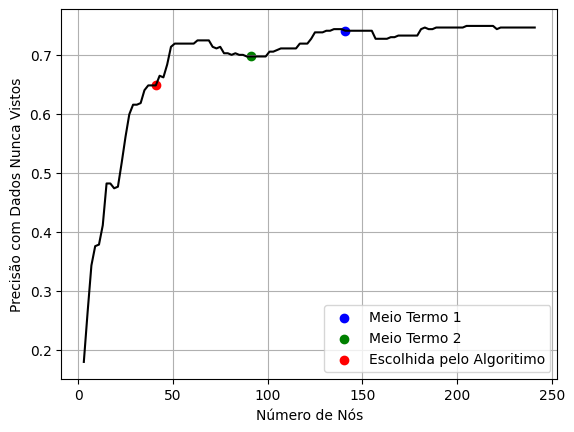

In [16]:
plotEvaluation = []
plotNodes = []
for tree in range(len(pruner.treesWarehouse)):
    plotNodes.append(len(pruner.treesWarehouse[tree].treeShape))
    predictions = pruner.treesWarehouse[tree].predict(data_test)
    plotEvaluation.append(pruner.treesWarehouse[tree].accuracy(label_test, predictions))


plt.plot(plotNodes, plotEvaluation, color='Black', label='')

plt.scatter(bestModels[0][1], bestModels[0][2], color='blue', label='Meio Termo 1')
plt.scatter(bestModels[1][1], bestModels[1][2], color='green', label='Meio Termo 2')
plt.scatter(bestModels[2][1], bestModels[2][2], color='red', label='Escolhida pelo Algoritimo')

plt.xlabel('Número de Nós')
plt.ylabel('Precisão com Dados Nunca Vistos')
plt.legend()
plt.title('')
plt.grid(True)
plt.show()

### Método de Poda - Regressão

In [ ]:
#criação de um dataset para regressão

import numpy as np
import random as r

funcao1 = lambda x: 7*x + 45
funcao2 = lambda x: 6*x**2 - 4*x + 5
funcao3 = lambda x: 7*x**3 - 47*x**2 + 6*x + 34

def grau1(x):
  return 7*x, 45

def grau2(x):
  return 6*x**2, 4*x, 5

def grau3(x):
  return 7*x**3, 47*x**2, 6*x, 34

funcao = funcao1

sample_x = 250
range_x = []

for i in range(-150, 150):
  range_x.append(i)

random_samples = r.sample(range_x, sample_x)

data = []
label = []
data_plot = []

for x in random_samples:
    data.append(grau1(x))
    data_plot.append([x])
    label.append(funcao(x))

data = np.array(data)
label = np.array(label)

len(data)*0.2

In [ ]:
pontoDeDivisao = 100

data_train = data[pontoDeDivisao:]
label_train = label[pontoDeDivisao:]
data_test = data[0:pontoDeDivisao]
label_test = label[0:pontoDeDivisao]

print(f"Divisores: {find_divisors(len(data_train))}")

In [ ]:
26.11164751668147*150

In [ ]:
TCV = TenCrossValidation(data_train.tolist(), label_train.tolist())
pruner, bestModels = TCV.find_best_models(15, 1)

In [ ]:
# Para procurar manualmente:
index = 10

print(f"Index: {index}")
print(pruner.treesWarehouse[index].treeShape)
print(f"Número de Nós: {len(pruner.treesWarehouse[index].treeShape)}")
predictions = pruner.treesWarehouse[index].predict(data_test)
evaluation = pruner.treesWarehouse[index].accuracy(label_test, predictions)
print(f"Evaluation: {evaluation}")

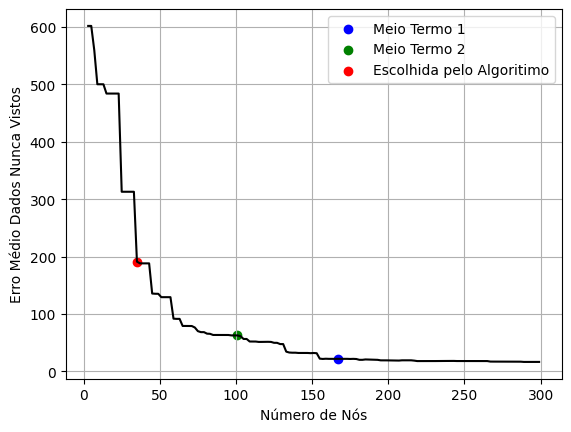

In [ ]:
plotEvaluation = []
plotNodes = []
for tree in range(len(pruner.treesWarehouse)):
    plotNodes.append(len(pruner.treesWarehouse[tree].treeShape))
    predictions = pruner.treesWarehouse[tree].predict(data_test)
    plotEvaluation.append(pruner.treesWarehouse[tree].accuracy(label_test, predictions))


plt.plot(plotNodes, plotEvaluation, color='Black', label='')

plt.scatter(bestModels[0][1], bestModels[0][2], color='blue', label='Meio Termo 1')
plt.scatter(bestModels[1][1], bestModels[1][2], color='green', label='Meio Termo 2')
plt.scatter(bestModels[2][1], bestModels[2][2], color='red', label='Escolhida pelo Algoritimo')

plt.xlabel('Número de Nós')
plt.ylabel('Erro Médio Dados Nunca Vistos')
plt.legend()
plt.title('')
plt.grid(True)
plt.show()

### Random Forest - Classificação

In [ ]:
# Execução da Floresta:

from sklearn import datasets
from sklearn.model_selection import train_test_split

#data = datasets.load_wine()
#data = datasets.load_breast_cancer()
data = datasets.load_digits()
#data = datasets.load_iris()

data, label = data.data, data.target

data_train, data_test, label_train, label_test = train_test_split(
    data, label, test_size=0.4, random_state=1234
)

model = RandomForest(num_trees=25, maxDepth=5, mode=0)
model.fit(data_train, label_train)
predictions = model.predict(data_test)

forest_result = model.trees[0].accuracy(label_test, predictions)

Round Geral: 0
Round Geral: 1
Round Geral: 2
Round Geral: 3
Round Geral: 4
Round Geral: 5
Round Geral: 6
Round Geral: 7
Round Geral: 8
Round Geral: 9
Round Geral: 10
Round Geral: 11
Round Geral: 12
Round Geral: 13
Round Geral: 14
Round Geral: 15
Round Geral: 16
Round Geral: 17
Round Geral: 18
Round Geral: 19
Round Geral: 20
Round Geral: 21
Round Geral: 22
Round Geral: 23
Round Geral: 24


In [ ]:
forest_result

0.9098998887652948

### Random Forest and Pruning - Classificação

In [ ]:
from sklearn import datasets

#data = datasets.load_iris()
#data = datasets.load_wine()
#data = datasets.load_breast_cancer()
data = datasets.load_digits()


data, label = data.data, data.target

len(data)*0.2

In [ ]:
# A divisão dos dados e a escolha do número das partições ainda é manual, entre 10 e 15 partições está bom pelos testes.

# Pro load digits fica 367
# load wine fica 35
# load iris fica 30
# load breast cancer fica 114

pontoDeDivisao = 367

data_train = data[pontoDeDivisao:]
label_train = label[pontoDeDivisao:]
data_test = data[0:pontoDeDivisao]
label_test = label[0:pontoDeDivisao]

print(f"Divisores: {find_divisors(len(data_train))}")